In [34]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
import holidays

In [35]:
df = pd.read_parquet("all_tlc_data_cleaned.parquet")
df.rename({'datetime':'timestamp'}, axis=1,inplace=True)

In [36]:
df_wth = pd.read_csv("meteostat_weather.csv")

In [37]:
df_wth.rename({'time':'timestamp'}, axis=1,inplace=True)
df_wth

,timestamp,temp,dwpt,rhum,prcp,pres,coco
0,2021-01-01 00:00:00,4.0,-4.0,56.0,0.0,1026.3,4.0
1,2021-01-01 01:00:00,3.0,-4.0,60.0,0.0,1027.7,4.0
2,2021-01-01 02:00:00,3.0,-4.0,60.0,0.0,1028.1,4.0
3,2021-01-01 03:00:00,2.0,-3.9,65.0,0.0,1029.2,3.0
4,2021-01-01 04:00:00,2.0,-5.0,60.0,0.0,1029.9,3.0
...,...,...,...,...,...,...,...
30212,2024-06-12 20:00:00,25.6,10.6,39.0,0.0,1015.0,3.0
30213,2024-06-12 21:00:00,24.6,11.2,43.0,0.0,1014.9,3.0
30214,2024-06-12 22:00:00,23.1,14.4,58.0,0.0,1015.0,3.0
30215,2024-06-12 23:00:00,21.5,15.6,69.0,0.0,1015.1,3.0


In [38]:
df_wth['timestamp'] = df_wth['timestamp'].astype('datetime64[us]')
df_wth['timestamp'] = pd.to_datetime(df_wth['timestamp'])
df_wth['coco'] = df_wth['coco'].astype('category')


In [39]:
df_wth.dtypes

timestamp    datetime64[us]
temp                float64
dwpt                float64
rhum                float64
prcp                float64
pres                float64
coco               category
dtype: object

In [40]:
df.sort_values(by=['timestamp'])

,timestamp,location,passenger_count
0,2021-01-01,3,132
162,2021-01-01,171,84
163,2021-01-01,172,35
164,2021-01-01,173,202
165,2021-01-01,174,350
...,...,...,...
7319637,2024-04-01,90,1
7319638,2024-04-01,107,1
7319639,2024-04-01,163,6
7319640,2024-04-01,225,1


In [41]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [42]:
df_wth.sort_values(by=['timestamp'])

,timestamp,temp,dwpt,rhum,prcp,pres,coco
0,2021-01-01 00:00:00,4.0,-4.0,56.0,0.0,1026.3,4.0
1,2021-01-01 01:00:00,3.0,-4.0,60.0,0.0,1027.7,4.0
2,2021-01-01 02:00:00,3.0,-4.0,60.0,0.0,1028.1,4.0
3,2021-01-01 03:00:00,2.0,-3.9,65.0,0.0,1029.2,3.0
4,2021-01-01 04:00:00,2.0,-5.0,60.0,0.0,1029.9,3.0
...,...,...,...,...,...,...,...
30212,2024-06-12 20:00:00,25.6,10.6,39.0,0.0,1015.0,3.0
30213,2024-06-12 21:00:00,24.6,11.2,43.0,0.0,1014.9,3.0
30214,2024-06-12 22:00:00,23.1,14.4,58.0,0.0,1015.0,3.0
30215,2024-06-12 23:00:00,21.5,15.6,69.0,0.0,1015.1,3.0


In [43]:
df.dtypes

timestamp          datetime64[us]
location                    int64
passenger_count             int64
dtype: object

In [44]:
df = df.join(df_wth.set_index('timestamp'), on='timestamp', how='left')

In [45]:
df_wth = df_wth.set_index("timestamp")

In [46]:
df = df.rename({'location': 'item_id', 'passenger_count':'target'}, axis=1)

In [47]:
df

,timestamp,item_id,target,temp,dwpt,rhum,prcp,pres,coco
0,2021-01-01,3,132,4.0,-4.0,56.0,0.0,1026.3,4.0
1,2021-01-01,4,234,4.0,-4.0,56.0,0.0,1026.3,4.0
2,2021-01-01,5,19,4.0,-4.0,56.0,0.0,1026.3,4.0
3,2021-01-01,6,37,4.0,-4.0,56.0,0.0,1026.3,4.0
4,2021-01-01,7,493,4.0,-4.0,56.0,0.0,1026.3,4.0
...,...,...,...,...,...,...,...,...,...
7319638,2024-04-01,107,1,13.3,-0.7,38.0,0.0,1014.4,3.0
7319639,2024-04-01,163,6,13.3,-0.7,38.0,0.0,1014.4,3.0
7319640,2024-04-01,225,1,13.3,-0.7,38.0,0.0,1014.4,3.0
7319641,2024-04-01,226,1,13.3,-0.7,38.0,0.0,1014.4,3.0


In [48]:
static_features_df = pd.read_csv("taxi_zone_lookup.csv")
static_features_df.rename({'LocationID': 'item_id'}, axis=1, inplace=True)
static_features_df

,item_id,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [49]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=static_features_df,
)



In [50]:
def add_weekends_holidays(data: TimeSeriesDataFrame):
    WEEKEND_INDICES = [5, 6]
    timestamps = data.index.get_level_values("timestamp")
    data["weekend"] = timestamps.weekday.isin(WEEKEND_INDICES).astype(float)
    data.head()

    # Get US holidays
    country_holidays = holidays.country_holidays(
        country="US",  
        years=range(timestamps.min().year, timestamps.max().year + 1),
    )
    # Get dummies
    holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float)
    # Reindex by hour
    holidays_df = holidays_df.reindex(timestamps.date).fillna(0)
    # Add holidays col, 1 if any of the holidays, 0 otherwise
    data['holiday'] = holidays_df.max(axis=1).values

In [51]:
add_weekends_holidays(data)

In [52]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)


In [53]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="initial_model",
    target="target",
    eval_metric="MASE",
    freq='h',
    known_covariates_names=['temp', 'dwpt', 'rhum', 'prcp', 'pres', 'coco', 'weekend',
       'holiday'],
    verbosity=4
)

predictor.fit(
    train_data,
    presets="high_quality"
)

Beginning AutoGluon training...
AutoGluon will save models to 'initial_model'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       5.79 GB / 15.90 GB (36.4%)
Disk Space Avail:   2030.22 GB / 2794.50 GB (72.7%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['temp',
                            'dwpt',
                            'rhum',
                            'prcp',
                            'pres',
                            'coco',
                            'weekend',
                            'holiday'],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'r

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-1.0797       = Validation score (-MASE)
	4.74    s     = Training runtime
	4014.40 s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. 
	CUDA out of memory. Tried to allocate 5.51 GiB. GPU 0 has a total capacty of 12.00 GiB of which 3.73 GiB is free. Of the allocated memory 6.20 GiB is allocated by PyTorch, and 194.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Training timeseries model DeepAR. 
	-1.1142       = Validation score (-MASE)
	349.45  s     = Training runtime
	88.81   s     = Validation (prediction) runtime
Training timeseries model PatchTST. 
	-0.9012       = Validation score (-MASE)
	202.84  s     = Training runtime
	16.19   s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'Chronos[base]': 0.28, 'DeepAR': 0.08, 'DirectTabu

In [55]:
predictor.leaderboard(test_data)


data with frequency 'None' has been resampled to frequency 'h'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


NetworkXError: The node Naive is not in the digraph.

In [ ]:
prediction_length

2160

In [57]:
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=prediction_length, freq='H')
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)
add_weekends_holidays(known_covariates)
known_covariates = known_covariates.join(df_wth, on='timestamp', how='left')

c:\Users\Daniel\miniconda3\envs\comp47360_autogluon\lib\site-packages\autogluon\timeseries\utils\forecast.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


In [58]:
predictions = predictor.predict(train_data, known_covariates=known_covariates)
predictions.head()

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2        0.3  \
item_id timestamp                                                         
3       2024-01-01 23:00:00  92.864509  73.994625  79.501138  85.836548   
        2024-01-02 00:00:00  68.976479  49.124388  55.976652  60.856230   
        2024-01-02 01:00:00  54.885617  31.672141  39.153488  44.844509   
        2024-01-02 02:00:00  47.763962  23.303429  31.556015  37.436433   
        2024-01-02 03:00:00  40.116125  18.502916  26.020988  31.275556   

                                   0.4        0.5        0.6         0.7  \
item_id timestamp                                                          
3       2024-01-01 23:00:00  89.365370  92.864509  96.033362  100.132919   
        2024-01-02 00:00:00  64.936209  68.976479  72.460008   76.503329   
        2024-01-02 01:00:00  50.516053  54.885617  59.543202   64.775250   
        2024-01-02 02:00:00  42.781381  47.763962  53.197598   57.950826   
        2024-01-02 03:00:00  35.647475  40.116125  44.314524   49.017561   

                                    0.8         0.9  
item_id timestamp                                    
3       2024-01-01 23:00:00  105.834513  111.856425  
        2024-01-02 00:00:00   81.251308   88.062877  
        2024-01-02 01:00:00   70.812601   79.020094  
        2024-01-02 02:00:00   65.079636   73.139236  
        2024-01-02 03:00:00   54.723339   62.962859

In [59]:
predictions

mean        0.1        0.2        0.3  \
item_id timestamp                                                         
3       2024-01-01 23:00:00  92.864509  73.994625  79.501138  85.836548   
        2024-01-02 00:00:00  68.976479  49.124388  55.976652  60.856230   
        2024-01-02 01:00:00  54.885617  31.672141  39.153488  44.844509   
        2024-01-02 02:00:00  47.763962  23.303429  31.556015  37.436433   
        2024-01-02 03:00:00  40.116125  18.502916  26.020988  31.275556   
...                                ...        ...        ...        ...   
110     2022-04-23 13:00:00   1.162488  -4.694415  -2.658680  -1.212195   
        2022-04-23 14:00:00   1.175596  -4.743405  -2.683902  -1.222858   
        2022-04-23 15:00:00   1.237554  -4.686074  -2.625246  -1.162048   
        2022-04-23 16:00:00   1.245785  -4.752896  -2.652663  -1.174677   
        2022-04-23 17:00:00   1.271556  -4.723316  -2.630340  -1.153249   

                                   0.4        0.5        0.6         0.7  \
item_id timestamp                                                          
3       2024-01-01 23:00:00  89.365370  92.864509  96.033362  100.132919   
        2024-01-02 00:00:00  64.936209  68.976479  72.460008   76.503329   
        2024-01-02 01:00:00  50.516053  54.885617  59.543202   64.775250   
        2024-01-02 02:00:00  42.781381  47.763962  53.197598   57.950826   
        2024-01-02 03:00:00  35.647475  40.116125  44.314524   49.017561   
...                                ...        ...        ...         ...   
110     2022-04-23 13:00:00   0.013135   1.162488   2.309904    3.539226   
        2022-04-23 14:00:00   0.018608   1.175596   2.335751    3.578101   
        2022-04-23 15:00:00   0.080248   1.237554   2.395686    3.634803   
        2022-04-23 16:00:00   0.080008   1.245785   2.413685    3.667735   
        2022-04-23 17:00:00   0.101917   1.271556   2.439635    3.693132   

                                    0.8         0.9  
item_id timestamp                                    
3       2024-01-01 23:00:00  105.834513  111.856425  
        2024-01-02 00:00:00   81.251308   88.062877  
        2024-01-02 01:00:00   70.812601   79.020094  
        2024-01-02 02:00:00   65.079636   73.139236  
        2024-01-02 03:00:00   54.723339   62.962859  
...                                 ...         ...  
110     2022-04-23 13:00:00    4.987280    7.020180  
        2022-04-23 14:00:00    5.037620    7.100590  
        2022-04-23 15:00:00    5.102995    7.164549  
        2022-04-23 16:00:00    5.148935    7.239604  
        2022-04-23 17:00:00    5.172501    7.277297  

[563760 rows x 10 columns]

data with frequency 'None' has been resampled to frequency 'h'.


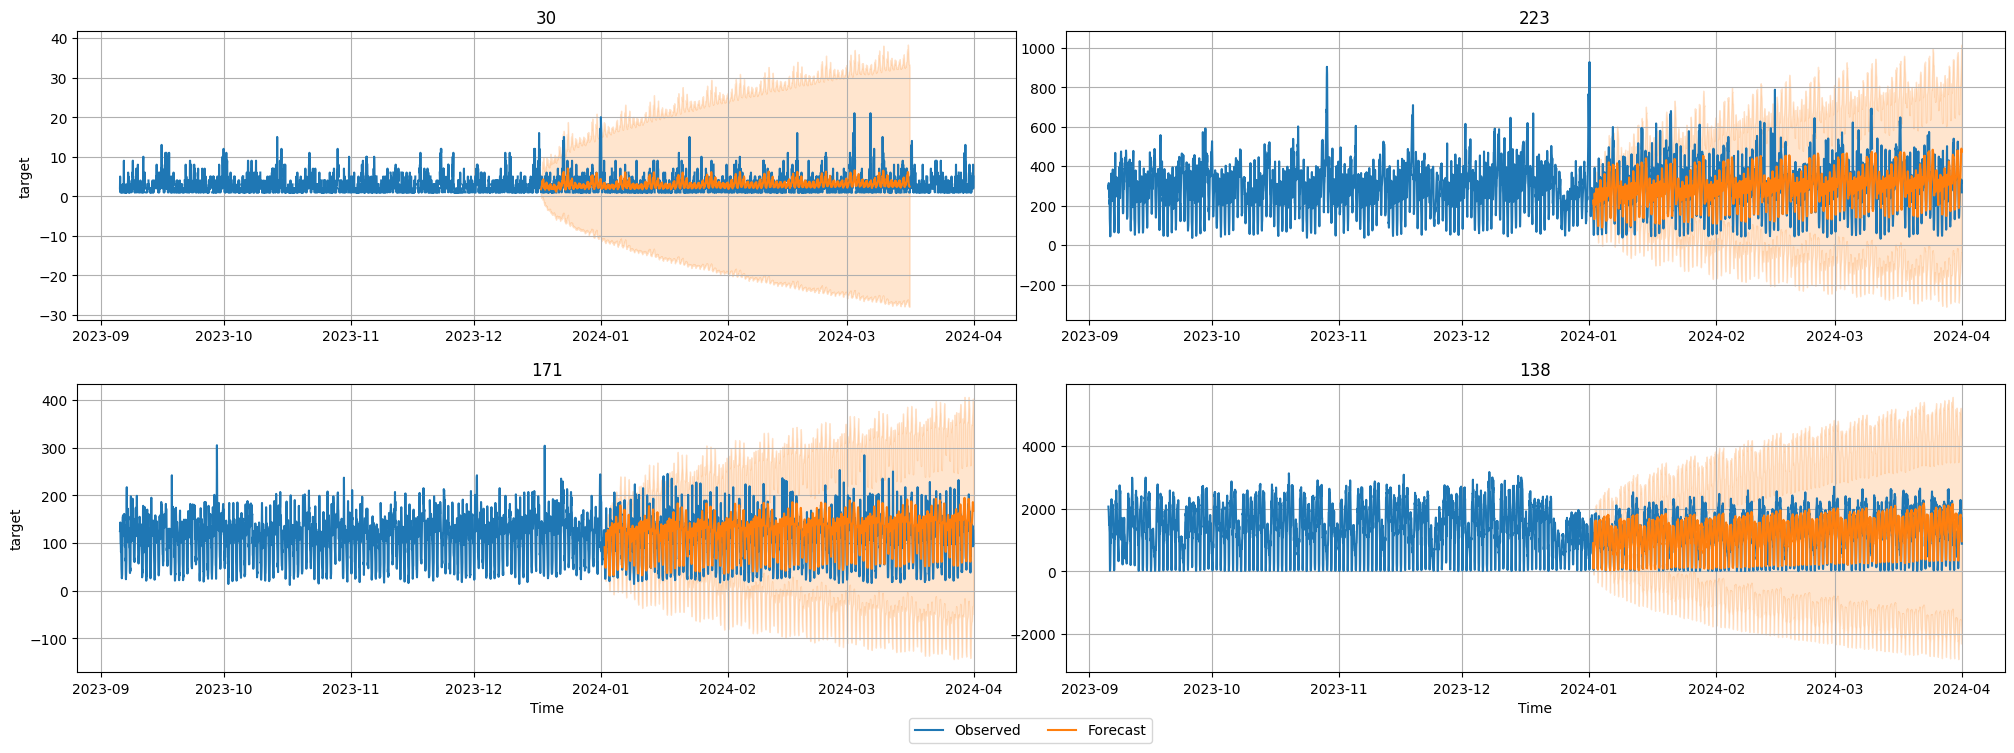

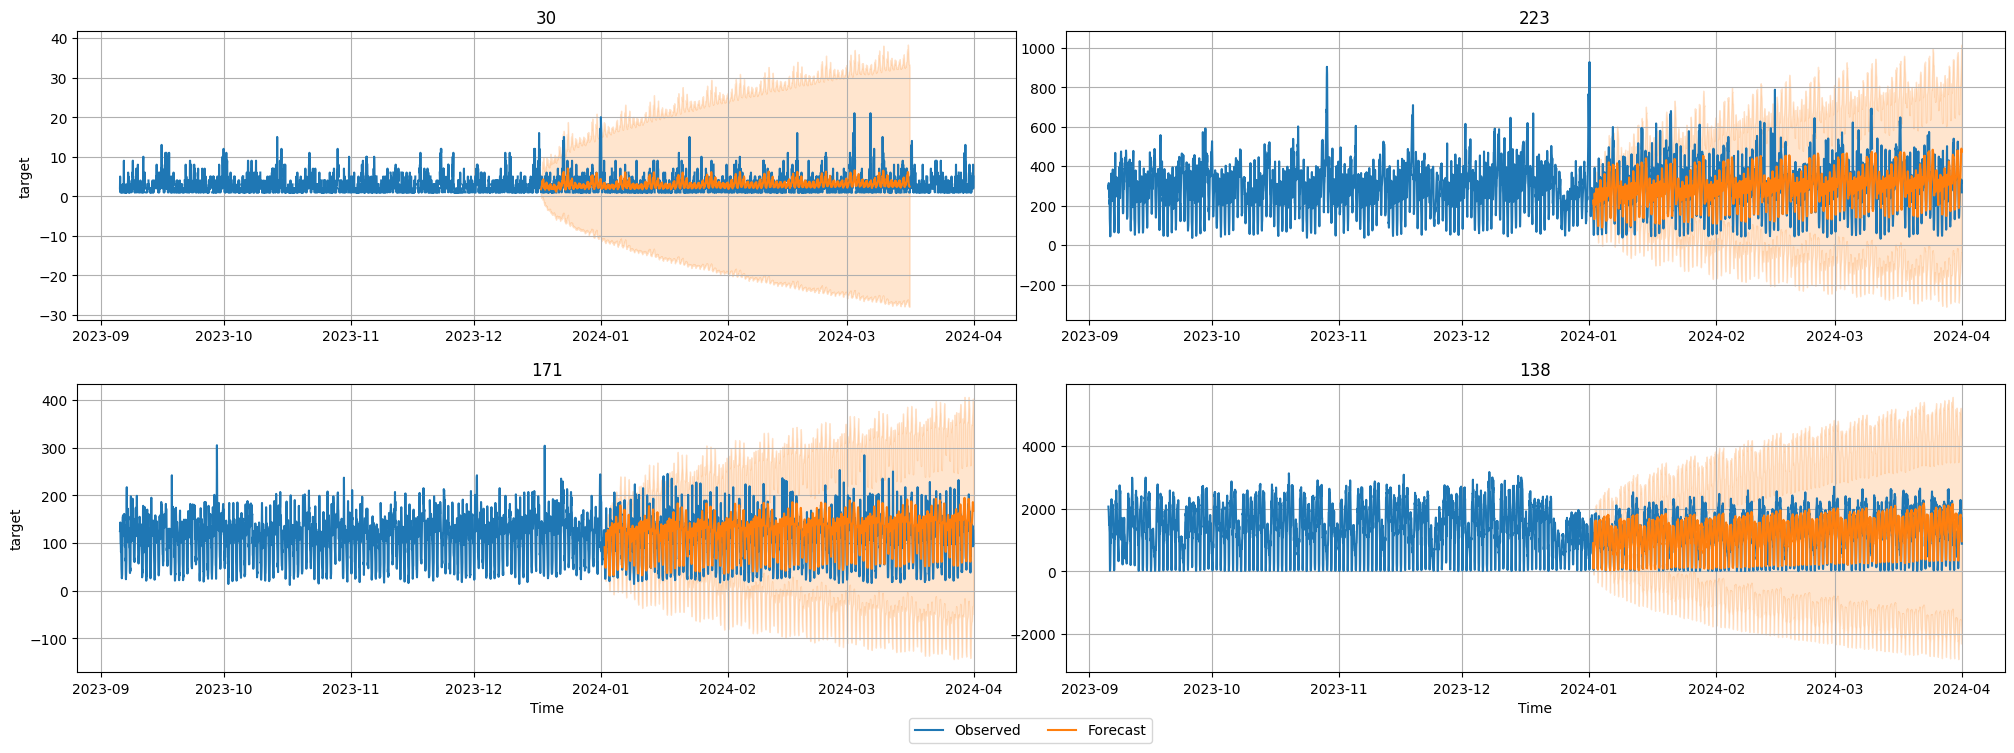

In [60]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=5000, max_num_item_ids=4)